# Analiza zbioru danych o samochodach używanych

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

# pd.set_option("display.max_columns", None)


Wyświetlamy head


In [ ]:
df = pd.read_csv("used_car_price_dataset_extended.csv")
df.head()


make_year  mileage_kmpl  engine_cc fuel_type  owner_count  price_usd  \
0       2001          8.17       4000    Petrol            4    8587.64   
1       2014         17.59       1500    Petrol            4    5943.50   
2       2023         18.09       2500    Diesel            5    9273.58   
3       2009         11.28        800    Petrol            1    6836.24   
4       2005         12.23       1000    Petrol            2    4625.79   

       brand transmission  color service_history  accidents_reported  \
0  Chevrolet       Manual  White             NaN                   0   
1      Honda       Manual  Black             NaN                   0   
2        BMW    Automatic  Black            Full                   1   
3    Hyundai       Manual   Blue            Full                   0   
4     Nissan    Automatic    Red            Full                   0   

  insurance_valid  
0              No  
1             Yes  
2             Yes  
3             Yes  
4             Yes

### Podstawowe informacje o danych

In [ ]:
df.info()
df.isna().sum().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make_year           10000 non-null  int64  
 1   mileage_kmpl        10000 non-null  float64
 2   engine_cc           10000 non-null  int64  
 3   fuel_type           10000 non-null  object 
 4   owner_count         10000 non-null  int64  
 5   price_usd           10000 non-null  float64
 6   brand               10000 non-null  object 
 7   transmission        10000 non-null  object 
 8   color               10000 non-null  object 
 9   service_history     7962 non-null   object 
 10  accidents_reported  10000 non-null  int64  
 11  insurance_valid     10000 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 937.6+ KB


np.int64(2038)

Sprawdzamy procent brakujących wartośći

In [ ]:
missing_val_percentage = lambda df: (df.isnull().sum() / len(df)).sort_values(ascending = False)
missing_val_percentage(df)

service_history       0.2038
make_year             0.0000
engine_cc             0.0000
mileage_kmpl          0.0000
fuel_type             0.0000
owner_count           0.0000
brand                 0.0000
price_usd             0.0000
transmission          0.0000
color                 0.0000
accidents_reported    0.0000
insurance_valid       0.0000
dtype: float64

NaN do None


In [ ]:
cols_to_fix = ['service_history', 'color']  # lub inne, w których to występuje

for col in cols_to_fix:
    df[col] = df[col].fillna('None')

In [ ]:
missing_val_percentage = lambda df: (df.isnull().sum() / len(df)).sort_values(ascending = False)
missing_val_percentage(df)

make_year             0.0
mileage_kmpl          0.0
engine_cc             0.0
fuel_type             0.0
owner_count           0.0
price_usd             0.0
brand                 0.0
transmission          0.0
color                 0.0
service_history       0.0
accidents_reported    0.0
insurance_valid       0.0
dtype: float64

Dane są kompletne. To none w service history jest parametrem

### Czyszczenie danych i tworzenie nowych cech

### Wizualizacje danych

In [ ]:
fig = px.histogram(df, x="price_usd", nbins=50, title="Rozkład cen samochodów (USD)")
fig.show()


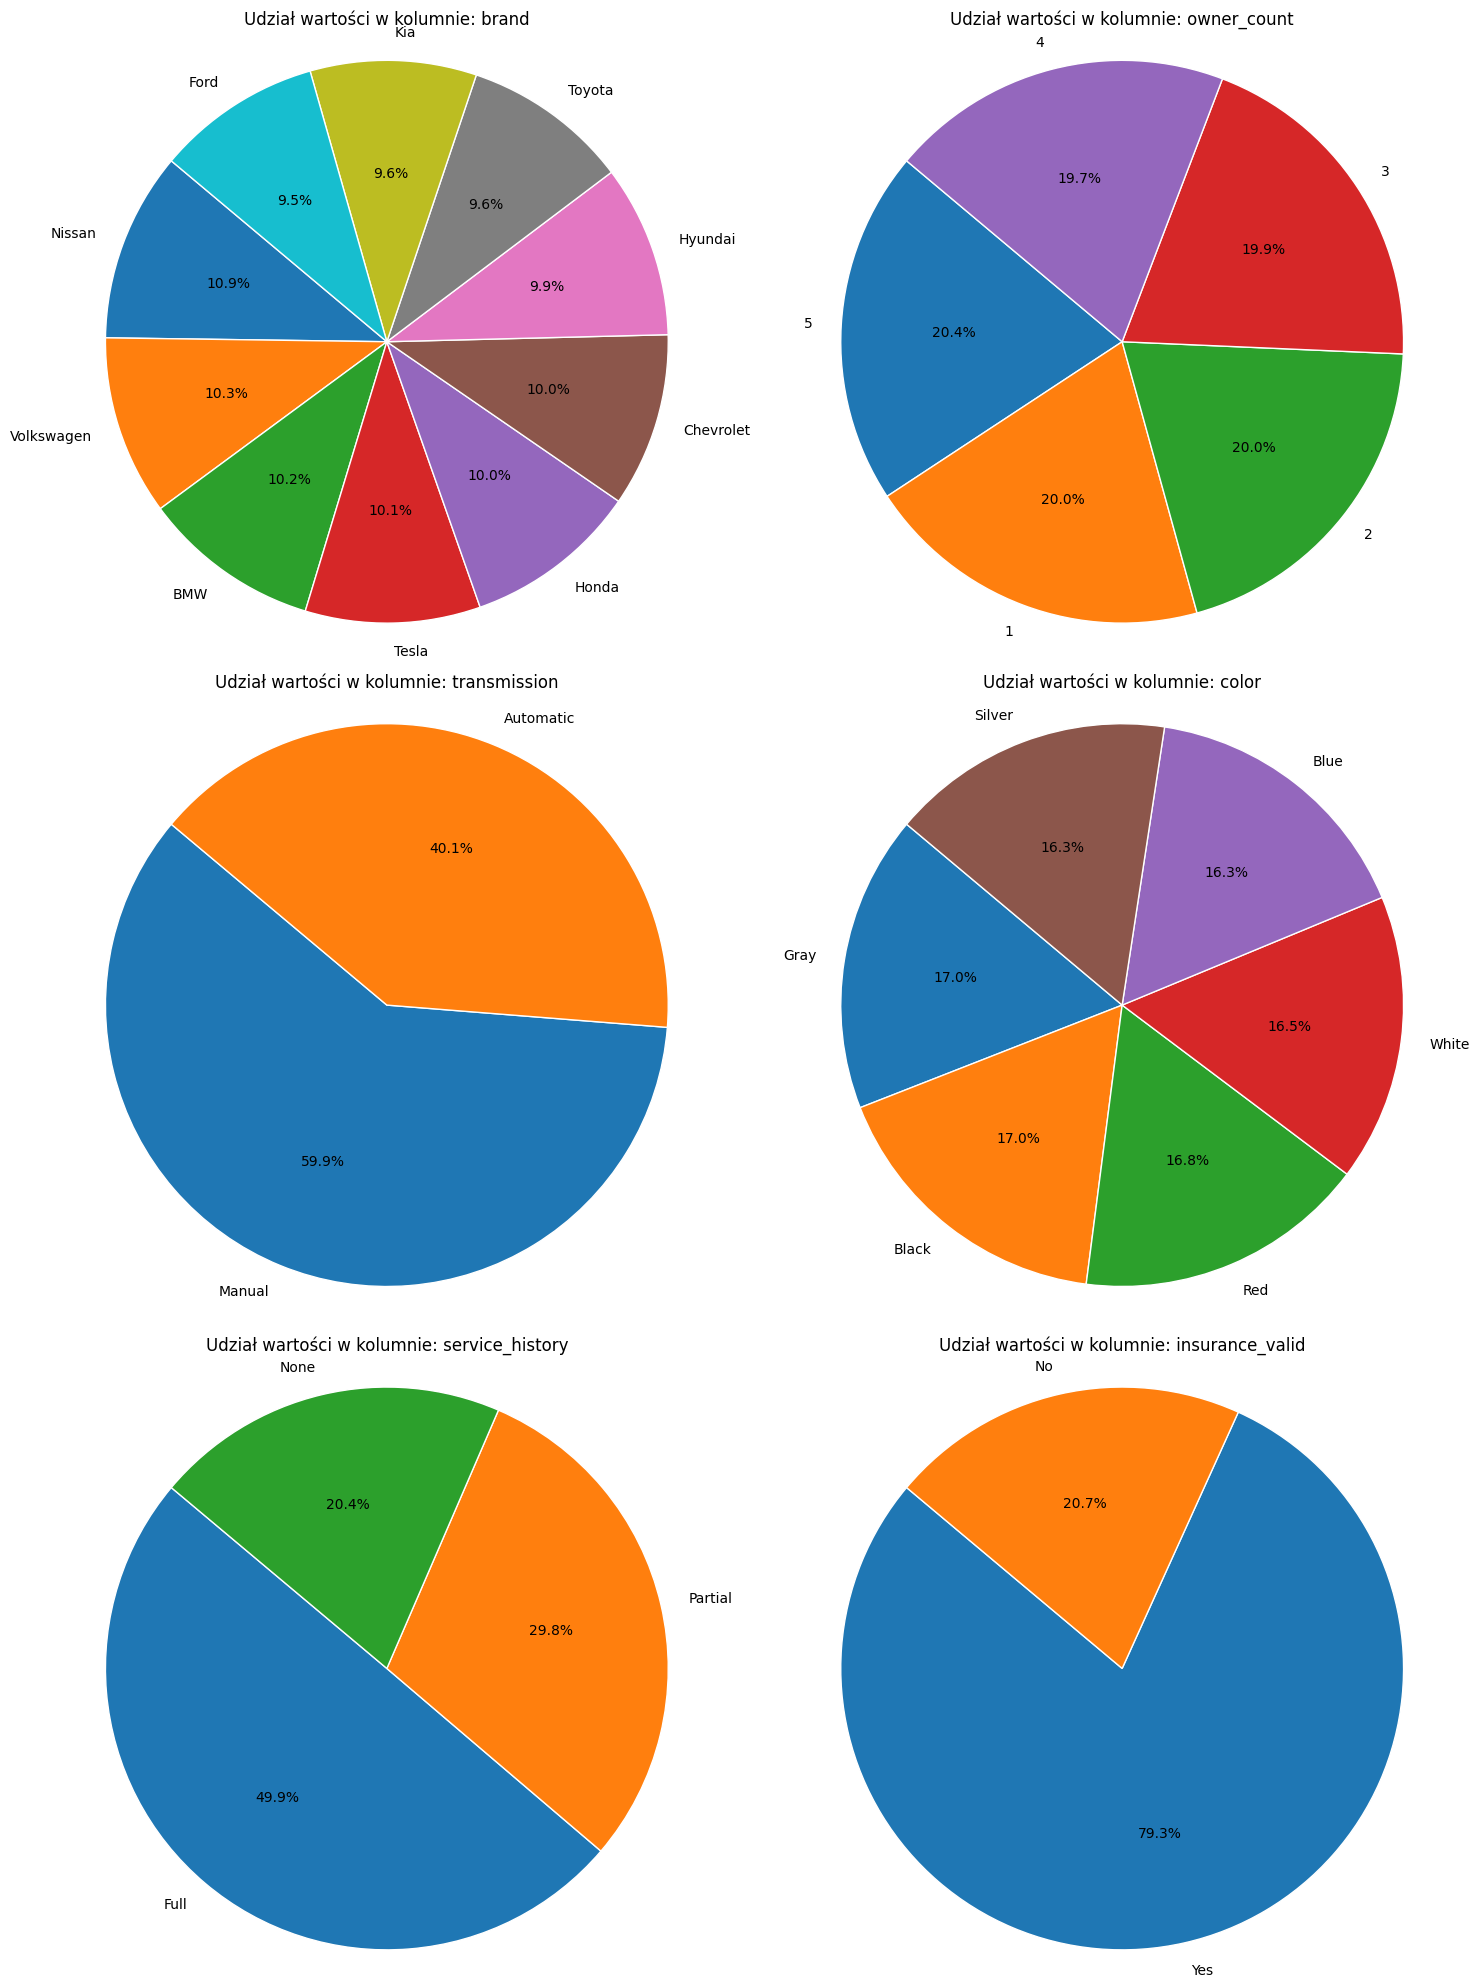

In [ ]:

# Lista kolumn do analizy
categorical_cols = ['brand','owner_count', 'transmission', 'color', 'service_history', 'insurance_valid']

# Wspólne parametry wykresów
wedge_props = {'edgecolor': 'white'}
plt.figure(figsize=(15, 20))

# Tworzenie wykresów w siatce 3x2
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    counts = df[col].value_counts()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=wedge_props)
    plt.title(f"Udział wartości w kolumnie: {col}")
    plt.axis('equal')



plt.tight_layout()
plt.show()


In [ ]:
fig = px.scatter(df, x="make_year", y="price_usd", color="fuel_type", title="Cena vs data produkcji")
fig.show()


In [ ]:
top10_expensive = df.sort_values(by='price_usd', ascending=False).head(10)
print(top10_expensive[['brand', 'make_year', 'price_usd', 'engine_cc', 'fuel_type', 'mileage_kmpl']])


           brand  make_year  price_usd  engine_cc fuel_type  mileage_kmpl
5173     Hyundai       2015   17647.63       5000  Electric         25.36
5273       Tesla       2015   17395.45       5000  Electric         19.51
6512       Honda       2013   17155.52       5000  Electric         20.41
8848         Kia       2013   17044.39       5000  Electric         28.99
4470         BMW       2018   16945.60       4000  Electric         14.42
7198  Volkswagen       2002   16886.44       5000  Electric         33.44
9071   Chevrolet       2016   16826.37       5000  Electric         22.63
8348      Toyota       2021   16785.48       5000  Electric         19.33
4113  Volkswagen       2022   16765.07       5000  Electric         13.01
3458         BMW       2013   16759.39       5000  Electric         29.09


In [ ]:
top10_cheapest = df.sort_values(by='price_usd', ascending=True).head(10)
print(top10_cheapest[['brand', 'make_year', 'price_usd', 'engine_cc', 'fuel_type', 'mileage_kmpl']])

           brand  make_year  price_usd  engine_cc fuel_type  mileage_kmpl
5616      Nissan       2001     1000.0       1000    Diesel          9.00
7072      Toyota       2002     1000.0        800    Petrol         11.44
7192         BMW       1996     1000.0       1500    Petrol         11.76
1980  Volkswagen       1999     1000.0       1000    Petrol         21.45
617    Chevrolet       1995     1000.0       1000    Diesel         15.03
5875      Toyota       1996     1000.0       1500    Diesel          9.59
8430   Chevrolet       1995     1000.0       1200    Diesel         13.16
1434  Volkswagen       1999     1000.0       1800    Diesel          9.72
2681         Kia       1995     1000.0       1200    Diesel         10.56
9538       Tesla       1998     1000.0        800    Petrol         18.29


In [ ]:
figures = []
for col in ['make_year', 'mileage_kmpl', 'engine_cc', 'owner_count']:
    fig = px.scatter(
        df,
        x=col,
        y='price_usd',
        color='brand',
        title=f'CENA vs {col.upper()}',
        trendline='ols'
    )
    figures.append(fig)

# Zmienne kategoryczne – wykres pudełkowy (boxplot)
for col in ['brand', 'fuel_type', 'transmission', 'color', 'service_history', 'insurance_valid']:
    fig = px.box(
        df,
        x=col,
        y='price_usd',
        color=col,
        title=f'CENA vs {col.upper()}',
        points='all'
    )
    figures.append(fig)

# Wyświetlanie wykresów
for fig in figures:
    fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Zmienne numeryczne
num_cols = df.select_dtypes(include='number').columns

# Obliczenie liczby rzędów potrzebnych dla 2 kolumn
n = len(num_cols)
n_rows = (n // 2) + (n % 2)

# Lista kolorów do cyklicznego przypisania
colors = ['indianred', 'mediumseagreen', 'royalblue', 'darkorange', 'purple', 'cyan', 'magenta', 'goldenrod']

# Tworzenie siatki wykresów
fig = make_subplots(rows=n_rows, cols=2, subplot_titles=num_cols)

row_num, col_num = 1, 1
for i, col in enumerate(num_cols):
    fig.add_trace(
        go.Box(
            y=df[col],
            name=col,
            boxmean=True,
            marker_color=colors[i % len(colors)],
            hovertext=df['brand'] if 'brand' in df.columns else None
        ),
        row=row_num,
        col=col_num
    )
    # Przejście do kolejnej kolumny / wiersza
    if col_num == 2:
        col_num = 1
        row_num += 1
    else:
        col_num += 1

# Ustawienia layoutu
fig.update_layout(
    height=300 * n_rows,
    width=1000,
    title_text="📦 Wykresy pudełkowe zmiennych numerycznych (Plotly)",
    showlegend=False,
    template='plotly_white',
    margin=dict(t=80, b=40)
)

fig.show()


Widzimy że niektóre wartości odstają więc ich przycinamy


In [ ]:
# Funkcja do usuwania outlierów za pomocą IQR
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Wybieramy kolumny numeryczne do oczyszczenia
num_cols = ['price_usd', 'mileage_kmpl', 'engine_cc', 'owner_count']

# Tworzymy nowy DataFrame bez odstających wartości
df_no_outliers = remove_outliers_iqr(df, num_cols)

# Sprawdzenie ile wierszy zostało usuniętych
print(f"Oryginalnie: {df.shape[0]} wierszy")
print(f"Po usunięciu outlierów: {df_no_outliers.shape[0]} wierszy")


Oryginalnie: 10000 wierszy
Po usunięciu outlierów: 9907 wierszy


Sprawdzamy wynik działania na cenie


In [ ]:
import plotly.express as px

# Przykład: Boxplot ceny przed i po czyszczeniu
fig = px.box(df, y='price_usd', title='Cena (USD) z outlierami')
fig.show()

fig_clean = px.box(df_no_outliers, y='price_usd', title='Cena (USD) po usunięciu outlierów')
fig_clean.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Zmienne numeryczne
num_cols = df_no_outliers.select_dtypes(include='number').columns

# Obliczenie liczby rzędów potrzebnych dla 2 kolumn
n = len(num_cols)
n_rows = (n // 2) + (n % 2)

# Lista kolorów do cyklicznego przypisania
colors = ['indianred', 'mediumseagreen', 'royalblue', 'darkorange', 'purple', 'cyan', 'magenta', 'goldenrod']

# Tworzenie siatki wykresów
fig = make_subplots(rows=n_rows, cols=2, subplot_titles=num_cols)

row_num, col_num = 1, 1
for i, col in enumerate(num_cols):
    fig.add_trace(
        go.Box(
            y=df_no_outliers[col],
            name=col,
            boxmean=True,
            marker_color=colors[i % len(colors)],
            hovertext=df_no_outliers['brand'] if 'brand' in df_no_outliers.columns else None
        ),
        row=row_num,
        col=col_num
    )
    # Przejście do kolejnej kolumny / wiersza
    if col_num == 2:
        col_num = 1
        row_num += 1
    else:
        col_num += 1

# Ustawienia layoutu
fig.update_layout(
    height=300 * n_rows,
    width=1000,
    title_text="📦 Wykresy pudełkowe zmiennych numerycznych (Plotly)",
    showlegend=False,
    template='plotly_white',
    margin=dict(t=80, b=40)
)

fig.show()

Zależność ceny od poszczególnych czynników przycięciu wwartości






In [ ]:
figures = []
for col in ['make_year', 'mileage_kmpl', 'engine_cc', 'owner_count']:
    fig = px.scatter(
        df_no_outliers,
        x=col,
        y='price_usd',
        color='brand',
        title=f'CENA vs {col.upper()}',
        trendline='ols'
    )
    figures.append(fig)

# Zmienne kategoryczne – wykres pudełkowy (boxplot)
for col in ['brand', 'fuel_type', 'transmission', 'color', 'service_history', 'insurance_valid']:
    fig = px.box(
        df_no_outliers,
        x=col,
        y='price_usd',
        color=col,
        title=f'CENA vs {col.upper()}',
        points='all'
    )
    figures.append(fig)

# Wyświetlanie wykresów
for fig in figures:
    fig.show()

### Przygotowanie danych do modelowania

In [ ]:
X = df.drop("price_usd", axis=1)
y = df["price_usd"]

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Trenowanie i ocena modeli regresyjnych

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R2": r2}

pd.DataFrame(results).T


MSE        R2
Linear Regression  9.821137e+05  0.876549
Random Forest      1.176444e+06  0.852122
Neural Network     9.829867e+05  0.876440

### Wnioski końcowe na nieprzyciętym zbiorze

- Regresja liniowa oraz sieć neuronowa osiągają najwyższe dopasowanie (R² ≈ 0.877)
- Las losowy również daje dobre wyniki, choć trochę słabsze
- Cena samochodu jest silnie zależna od jego wieku oraz typu paliwa


In [ ]:
# Pełny zbiór testowy
X_full = df.drop('price_usd', axis=1)
y_full = df['price_usd']

# Zbiór uczący – przycięty z outlierów
X_train = df_no_outliers.drop('price_usd', axis=1)
y_train = df_no_outliers['price_usd']

# Kolumny numeryczne i kategoryczne – wykryte na podstawie pełnych danych
categorical_cols = X_full.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X_full.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Pipeline do przetwarzania danych numerycznych
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline do przetwarzania danych kategorycznych
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Łączny preprocessor
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_full)

    results[name] = {
        "MSE": mean_squared_error(y_full, y_pred),
        "R2": r2_score(y_full, y_pred)
    }
pd.DataFrame(results).T

MSE        R2
Linear Regression  998861.938465  0.872150
Random Forest      207038.332914  0.973500
Neural Network     999542.067730  0.872063

Wnioski na przyciętym

Random forest ma najwyższe dopasowanie